# Load packages

In [1]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
    
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

from scipy import optimize
from scipy.optimize import minimize
from scipy.stats import gumbel_r
from matplotlib.pyplot import cm
import math
import matplotlib
import matplotlib.colors as mcolors
from scipy.optimize import fsolve

import sympy
from sympy import *
from sympy import symbols, Eq, solve
from shapely.geometry import LineString


%matplotlib inline
plt.style.use('ggplot')
import warnings
from scipy.stats import pearsonr

# Catchment selection 

In [2]:
"""
LamaH: Catchment selection
The data set contains a selection of catchments with no human impact.
Snow fraction is checked by frac_snow < 0.1

"""
root = 'H:/My Drive/Delft/TUDELFT/Thesis/Data_used/Discharge/LamaH/'

frac_snow = pd.read_csv(f'{root}C_basins_intermediate_lowimp/1_attributes/Catchment_attributes.csv', delimiter=';', parse_dates=[0,1,2], skipinitialspace=True)
# display(frac_snow)

catchment_list_Lamah = []
for i in range(len(frac_snow)):
    if (frac_snow['frac_snow'][i]<0.1):
        catchment_list_Lamah.append(int(frac_snow['ID'][i]))
        
print(f'number of catchments selected:\n{len(catchment_list_Lamah)}')
print(catchment_list_Lamah)

number of catchments selected:
145
[32, 148, 150, 151, 162, 165, 166, 167, 168, 170, 171, 172, 174, 176, 177, 179, 189, 190, 191, 193, 194, 195, 229, 235, 239, 243, 287, 292, 310, 317, 324, 340, 341, 345, 346, 347, 348, 350, 352, 354, 361, 363, 390, 391, 395, 398, 411, 416, 428, 429, 430, 431, 432, 441, 446, 447, 450, 452, 455, 456, 458, 459, 460, 461, 463, 464, 465, 469, 506, 508, 511, 512, 515, 516, 518, 520, 523, 562, 590, 591, 592, 593, 594, 595, 598, 599, 608, 611, 612, 626, 627, 629, 630, 631, 632, 634, 635, 649, 650, 651, 654, 656, 662, 666, 674, 688, 689, 697, 698, 699, 700, 703, 704, 706, 719, 720, 742, 743, 746, 748, 750, 753, 754, 756, 757, 758, 762, 764, 766, 768, 769, 770, 772, 773, 774, 776, 778, 779, 784, 786, 788, 789, 791, 795, 796]


# Catchment descriptors 

In [3]:
#FUNCTIONS to compute the catchment descriptors.

#HAI
def HAI_calculate(temp, precipitation):

    temp_adjusted = np.zeros(12)
    
    for i in range(1,13):
        if temp[i] < 0:
            temp_adjusted[i-1] = 0
        elif temp[i] > 30:
            temp_adjusted[i-1] = 30
        else:
            temp_adjusted[i-1] = temp[i]            
        
    T = np.sum(temp_adjusted)
    HAI = (58.93 * (T/12))/precipitation
    
    return HAI


#Function for the Seasonality Index
def Seasonality_index(Annual_mean, Monthly_mean):
    SI = (1/Annual_mean) * np.sum(np.abs(Monthly_mean - (Annual_mean/12)))
    
    return SI

#Function for Seasonality Timing Index
def ST_calc(dP,dT):
    days = 366
    ST = dP[0] * np.sign(dT[0]) * np.cos((np.pi * (dP[1] - dT[1]))/days)
    return ST

#Functions to compute Seasonal variability indexes
def T_daily(dT):
    t = np.linspace(1,366,366)
    days = 366
    T = T_mean + dT[0] * np.sin((2*np.pi * (t-dT[1]))/days)
    return T

def Cal_T_daily(dT):
    days = 366
    T_calc = T_daily(dT)
    
    return (np.sum(np.abs(T_calc - T_obs)))/days

def P_daily(dP):
    t = np.linspace(1,366,366)
    days = 366
    P = P_mean * (1 + dP[0] * np.sin((2*np.pi * (t-dP[1]))/days))
    return P

def Cal_P_daily(dP):
    days = 366
    P_calc = P_daily(dP)
    
    return (np.sum(np.abs(P_calc - P_obs)))/days

def E_daily(dE):
#    t = np.linspace(1,366,366)
    t = np.linspace(1,366,366)

    days = 366
    E = E_mean * (1 + dE[0] * np.sin((2*np.pi * (t-dE[1]))/days))
    return E

def Cal_E_daily(dE):
    days = 366
    E_calc = E_daily(dE)
    
    return (np.sum(np.abs(E_calc - E_obs)))/days


#Function for the interstorm duration or low_prec_freq
def Interstorm_duration(P):
    interstorm = []
    count = 0

    for j in range(len(P)):
        if P[j] < 1:
            count += 1
        elif P[j] >= 1 and count > 0:
            interstorm.append(count)
            count = 0 
    interstorm_duration = np.mean(interstorm)
    return 

#Function to compute the root-zone storage capacity
def rootzone(df_out, RP):
    firstyear = df_out['hydroyear'].iloc[0]
    lastyear = df_out['hydroyear'].iloc[-1]
    df_out = df_out.drop(df_out[df_out['hydroyear']==firstyear].index)
    df_out = df_out.drop(df_out[df_out['hydroyear']==lastyear].index)
    years = df_out.groupby(['hydroyear'])
    SD = years['SD_sum'].max() - years['SD_sum'].min()
    var = gumbel_r.fit(SD)
    p = 1-1/RP
    Sr = gumbel_r.ppf(p, var[0],var[1])
    return(Sr, df_out)

## Load et0_mean

# LamaH: Load data

In [4]:
catch_att = pd.read_csv(f'{root}C_basins_intermediate_lowimp/1_attributes/Catchment_attributes.csv', delimiter=';', parse_dates=[0,1,2], skipinitialspace=True)
catch_att.index = catch_att['ID']

In [5]:
catchment_list = catchment_list_Lamah

for i in range(len(catchment_list)): 
    # Import data and select right dates
    data = pd.read_csv(f'{root}C_basins_intermediate_lowimp/2_timeseries/daily/'+str('ID_')+str(catchment_list[i])+str('.csv'),delimiter=';', skipinitialspace=True)
    data['date'] = pd.to_datetime(data['YYYY'].astype('str')+
                                 data['MM'].astype('str')+
                                 data['DD'].astype('str'),
                           format='%Y%m%d')
    data.loc[:,'dt'] = pd.to_datetime(data['date'])
    data.index = data['dt']
    data = data["1989-01-01":"2009-12-31"]
    
    
    outputdata = pd.read_csv(f'{root}F_hydrol_model/2_timeseries/'+str('ID_')+str(catchment_list[i])+str('.csv'),delimiter=';', skipinitialspace=True)
    outputdata['date'] = pd.to_datetime(outputdata['YYYY'].astype('str')+
                                 outputdata['MM'].astype('str')+
                                 outputdata['DD'].astype('str'),
                                        format='%Y%m%d')
    outputdata.loc[:,'dt'] = pd.to_datetime(outputdata['date'])
    outputdata.index = outputdata['dt']
    outputdata = outputdata["1989-01-01":"2009-12-31"]   
    
    data["qobs"] = outputdata["Qobs"]    
    
    # Compute mean values
    Ep = catch_att.loc[f"{catchment_list[i]}","et0_mean"]  # comes from catchment attributes 
    P = data['prec'].mean() 
    T = data['2m_temp_mean'].mean() 
    Q = data['qobs'].mean()
    Ea = data['total_et'].mean()
    
    # Compute Ea, AI, EI
    Ea = P - Q
    EI = Ea / P
    AI = Ep / P

# Plot Budyko

In [6]:
catchment_list = catchment_list_Lamah
plt.figure(figsize=(10,5)).suptitle("LamaH (n=59)",fontsize=20)
n_total = 0
negative_catchment_ids = []
negative_catchment_Q = []
negative_catchment_P = []
negative_catchment_Eagiven = []
negative_catchment_Ea_wb = []

accepted_catchment_ids = []
accepted_catchment_Q = []
accepted_catchment_P = []
accepted_catchment_Eagiven = []
accepted_catchment_Ea_wb = []


Ea_given = []
Ea_wb = []

for i in range(len(catchment_list)): 
    # Import data and select right dates
    data = pd.read_csv(f'{root}C_basins_intermediate_lowimp/2_timeseries/daily/'+str('ID_')+str(catchment_list[i])+str('.csv'),delimiter=';', skipinitialspace=True, na_values=-999)
    data['date'] = pd.to_datetime(data['YYYY'].astype('str')+
                                 data['MM'].astype('str')+
                                 data['DD'].astype('str'),
                           format='%Y%m%d')
    data.loc[:,'dt'] = pd.to_datetime(data['date'])
    data.index = data['dt']
    data = data["1989-01-01":"2009-12-31"]
    
    
    outputdata = pd.read_csv(f'{root}F_hydrol_model/2_timeseries/'+str('ID_')+str(catchment_list[i])+str('.csv'),delimiter=';', skipinitialspace=True, na_values=-999)
    outputdata['date'] = pd.to_datetime(outputdata['YYYY'].astype('str')+
                                 outputdata['MM'].astype('str')+
                                 outputdata['DD'].astype('str'),
                                        format='%Y%m%d')
    outputdata.loc[:,'dt'] = pd.to_datetime(outputdata['date'])
    outputdata.index = outputdata['dt']
    outputdata = outputdata["1989-01-01":"2009-12-31"]   
    
    data["qobs"] = outputdata["Qobs"]    
    
    # Compute mean values
    Ep = catch_att.loc[f"{catchment_list[i]}","et0_mean"]  # comes from catchment attributes 
    P = data['prec'].mean() 
    T = data['2m_temp_mean'].mean() 
    Q = data['qobs'].mean()
    Ea_calc = data['total_et'].mean()
    Ea_given.append(Ea_calc)
    
    # display(data)
    
    # Compute Ea, AI, EI
    Ea = P - Q
    Ea_wb.append(Ea)
    
    EI = Ea / P
    AI = Ep / P
    
    print(f'Catchment nr {i} ({catchment_list[i]}) has a given Ea of {Ea_calc} and Ea from P-Q of {Ea}, EI of {EI} and AI of {AI}')
        
        
    # Plot every catchment
    if Ea > 0 and AI > EI: 
        budyko_curve_x = np.arange(1, 3, 0.05)
        energy_limit_x = np.arange(0, 1.0001, 0.05)
        x = np.arange(0, 1.0001, 0.05)
        water_limit_y = 1 + budyko_curve_x*0
        energy_limit_y = energy_limit_x
        y = 1 + x*0
        plt.ylabel("Actual ET/P")
        plt.xlabel("Potential ET/P")
        plt.minorticks_on()
        plt.plot(energy_limit_x, energy_limit_y, c='k')
        plt.plot(budyko_curve_x, water_limit_y,c='k')
        
        plt.plot(AI, EI, marker='.', c = 'b')
        n_total += 1
        accepted_catchment_ids.append(catchment_list[i])
        accepted_catchment_Q.append(Q)
        accepted_catchment_P.append(P)
        accepted_catchment_Eagiven.append(Ea_calc)
        accepted_catchment_Ea_wb.append(Ea)
    else:
        negative_catchment_ids.append(catchment_list[i])
        negative_catchment_Q.append(Q)
        negative_catchment_P.append(P)
        negative_catchment_Eagiven.append(Ea_calc)
        negative_catchment_Ea_wb.append(Ea)
        
        
        
        


plt.savefig(f'{root}/Budyko.png')   
plt.close()

print(f'n_total:\n{n_total}')
print(f'negative_catchment_ids:\n {len(negative_catchment_ids)}')
diff = len(catchment_list_Lamah)-(n_total+len(negative_catchment_ids))
print(f'difference after non valid catchment selection:{diff}')

Catchment nr 0 (32) has a given Ea of 1.7044224250325946 and Ea from P-Q of 1.036161549819464, EI of 0.23647920737713019 and AI of 0.5386138189621748
Catchment nr 1 (148) has a given Ea of 1.6221408083441982 and Ea from P-Q of 3.057956975228162, EI of 0.804233255977265 and AI of 0.6022629393111469
Catchment nr 2 (150) has a given Ea of 1.6791655801825294 and Ea from P-Q of 2.7714576271186435, EI of 0.7729982196052876 and AI of 0.6331346874418172
Catchment nr 3 (151) has a given Ea of 1.6111877444589309 and Ea from P-Q of 2.7343989569752276, EI of 0.72509362363575 and AI of 0.6045984832141257
Catchment nr 4 (162) has a given Ea of 1.796910039113429 and Ea from P-Q of -1.0682086049543682, EI of -0.3041951979457852 and AI of 0.6407355194515163
Catchment nr 5 (165) has a given Ea of 1.7527913950456324 and Ea from P-Q of 0.12822294654498023, EI of 0.038493558443693315 and AI of 0.6724659917530859
Catchment nr 6 (166) has a given Ea of 1.8248070404172099 and Ea from P-Q of 2.6956401564537154

150


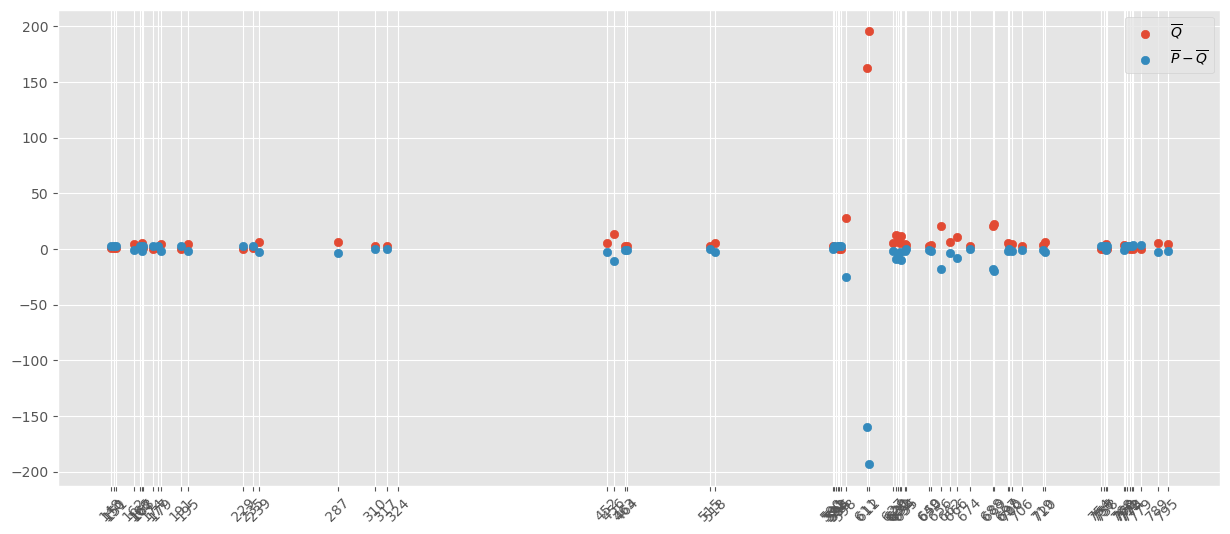

In [13]:
negatives = {'catchment':negative_catchment_ids, 'Q':negative_catchment_Q, 'P':negative_catchment_P, 'Eagiven':negative_catchment_Eagiven, 'Ea_wb':negative_catchment_Ea_wb}
#print(np.where(np.array(negative_catchment_ids)>0 np.array(negative_catchment_ids)<10000)[0])#np.where(np.array(negative_catchment_ids)>0)[0]])
print(negative_catchment_ids[negative_catchment_ids[0]>0])
neg_df = pd.DataFrame(negatives)

ax = plt.figure(figsize=(15, 6.18))

plt.scatter(neg_df.catchment, neg_df.Q, label='$\overline{Q}$')
#plt.scatter(neg_df.catchment, neg_df.P, label='P')
plt.scatter(neg_df.catchment, neg_df.P-neg_df.Q, label='$\overline{P}-\overline{Q}$')
#plt.xlim(500, 700)
plt.xticks(negative_catchment_ids, rotation=45)
#ax.tick_params(axis='x', labelrotation=45)
plt.legend()

165


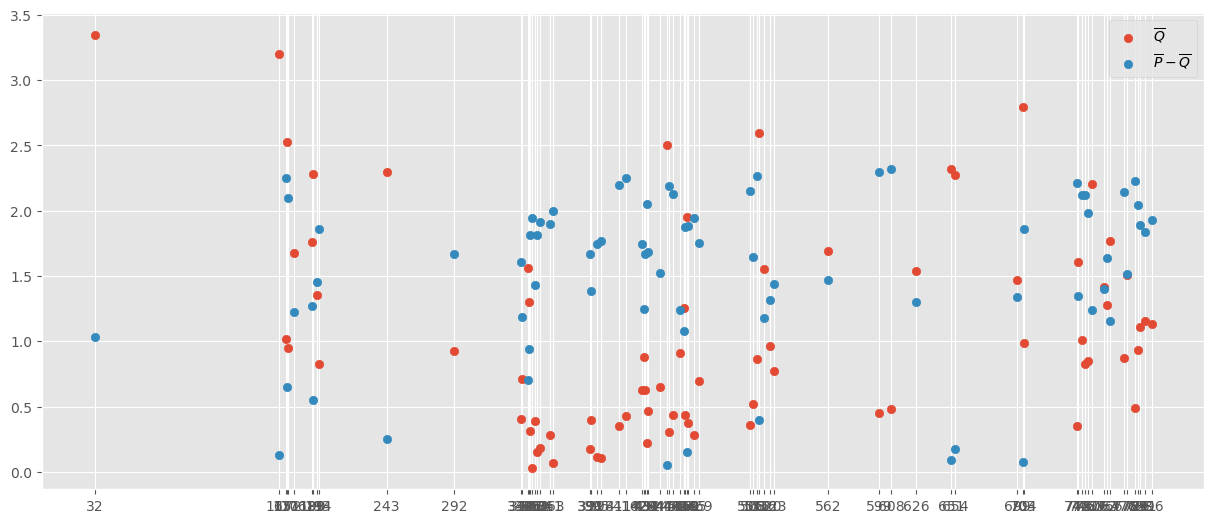

In [8]:
accepted = {'catchment':accepted_catchment_ids, 'Q':accepted_catchment_Q, 'P':accepted_catchment_P, 'Eagiven':accepted_catchment_Eagiven, 'Ea_wb':accepted_catchment_Ea_wb}
#print(np.where(np.array(accepted_catchment_ids)>0 np.array(accepted_catchment_ids)<10000)[0])#np.where(np.array(accepted_catchment_ids)>0)[0]])
print(accepted_catchment_ids[accepted_catchment_ids[0]>0])
acc_df = pd.DataFrame(accepted)

plt.figure(figsize=(15, 6.18))

plt.scatter(acc_df.catchment, acc_df.Q, label='$\overline{Q}$')
#plt.scatter(acc_df.catchment, acc_df.P, label='P')
plt.scatter(acc_df.catchment, acc_df.P-acc_df.Q, label='$\overline{P}-\overline{Q}$')
#plt.xlim(500, 700)
plt.xticks(accepted_catchment_ids)
plt.legend()

In [9]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [15]:
acc_df.to_excel('accepted_catchment_list.xlsx')
neg_df.to_excel('rejected_catchment_list.xlsx')
acc_df.to_csv('accepted_catchment_list.csv')
neg_df.to_csv('rejected_catchment_list.csv')

In [251]:
plt.figure(figsize=(10,5)).suptitle("LamaH (n=59)",fontsize=20)
n_total = 0


for i in range(len(negative_catchment_ids)): 
    # Import data and select right dates
    data = pd.read_csv(f'{root}C_basins_intermediate_lowimp/2_timeseries/daily/'+str('ID_')+str(negative_catchment_ids[i])+str('.csv'),delimiter=';', skipinitialspace=True, na_values=-999)
    data['date'] = pd.to_datetime(data['YYYY'].astype('str')+
                                 data['MM'].astype('str')+
                                 data['DD'].astype('str'),
                           format='%Y%m%d')
    data.loc[:,'dt'] = pd.to_datetime(data['date'])
    data.index = data['dt']
    data = data["1989-01-01":"2009-12-31"]
    
    
    outputdata = pd.read_csv(f'{root}F_hydrol_model/2_timeseries/'+str('ID_')+str(negative_catchment_ids[i])+str('.csv'),delimiter=';', skipinitialspace=True, na_values=-999)
    outputdata['date'] = pd.to_datetime(outputdata['YYYY'].astype('str')+
                                 outputdata['MM'].astype('str')+
                                 outputdata['DD'].astype('str'),
                                        format='%Y%m%d')
    outputdata.loc[:,'dt'] = pd.to_datetime(outputdata['date'])
    outputdata.index = outputdata['dt']
    outputdata = outputdata["1989-01-01":"2009-12-31"]   
    
    data["qobs"] = outputdata["Qobs"]    
    
    # Compute mean values
    Ep = catch_att.loc[f"{negative_catchment_ids[i]}","et0_mean"]  # comes from catchment attributes 
    P = data['prec'].mean() 
    T = data['2m_temp_mean'].mean() 
    Q = data['qobs'].mean()
    Ea_calc = data['total_et'].mean()
    
    # display(data)
    
    # Compute Ea, AI, EI
    Ea = P - Q
    EI = Ea / P
    AI = Ep / P
    
    print(f'Catchment nr {negative_catchment_ids[i]} has a given Ea of {Ea_calc} and Ea from P-Q of {Ea}, EI of {EI} and AI of {AI}')
        
        
    # Plot every catchment
     
    budyko_curve_x = np.arange(1, 3, 0.05)
    energy_limit_x = np.arange(0, 1.0001, 0.05)
    x = np.arange(0, 1.0001, 0.05)
    water_limit_y = 1 + budyko_curve_x*0
    energy_limit_y = energy_limit_x
    y = 1 + x*0
    plt.ylabel("Actual ET/P")
    plt.xlabel("Potential ET/P")
    plt.minorticks_on()
    plt.plot(energy_limit_x, energy_limit_y, c='k')
    plt.plot(budyko_curve_x, water_limit_y,c='k')

    plt.plot(AI, EI, marker='.', c = 'b')
    n_total += 1



plt.savefig(f'{root}/neg_Budyko.png')   
plt.close()
print(n_total)



Catchment nr 148 has a given Ea of 1.6221408083441982 and Ea from P-Q of 3.057956975228162, EI of 0.804233255977265 and AI of 0.6022629393111469
Catchment nr 150 has a given Ea of 1.6791655801825294 and Ea from P-Q of 2.7714576271186435, EI of 0.7729982196052876 and AI of 0.6331346874418172
Catchment nr 151 has a given Ea of 1.6111877444589309 and Ea from P-Q of 2.7343989569752276, EI of 0.72509362363575 and AI of 0.6045984832141257
Catchment nr 162 has a given Ea of 1.796910039113429 and Ea from P-Q of -1.0682086049543682, EI of -0.3041951979457852 and AI of 0.6407355194515163
Catchment nr 166 has a given Ea of 1.8248070404172099 and Ea from P-Q of 2.6956401564537154, EI of 0.7901501989939854 and AI of 0.6565922537951024
Catchment nr 167 has a given Ea of 1.6628878748370273 and Ea from P-Q of -1.6802803129074313, EI of -0.5150507807239065 and AI of 0.6835545427696665
Catchment nr 168 has a given Ea of 1.6066923076923076 and Ea from P-Q of 2.4491213753461683, EI of 0.753937237945986 an

Text(0, 0.5, 'calculated')

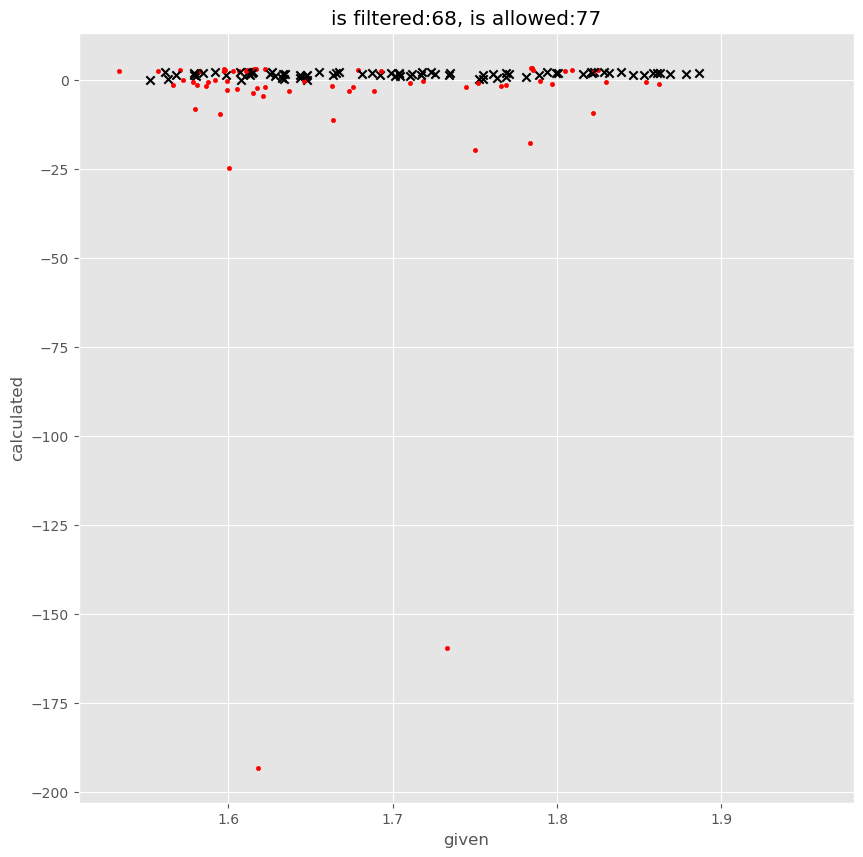

In [176]:
ax = plt.figure(figsize=(10, 10))
my_dict = {'catchment':catchment_list, 'Ea_given':Ea_given, 'Ea_wb':Ea_wb}
df = pd.DataFrame(my_dict)

plt.plot([0, np.max(Ea_given)], [0, np.max(Ea_wb)]) 

y = 0
n = 0


for i in range(len(df.catchment)):
    
    if np.any(negative_catchment_ids == df.catchment[i]):

        plt.scatter(df.Ea_given[i], df.Ea_wb[i], marker='.', color='red')
        
        y +=1
        
    elif np.any(negative_catchment_ids != df.catchment[i]):
        
        plt.scatter(df.Ea_given[i], df.Ea_wb[i], marker='x', color='black')
        
        n +=1

plt.title(f'is filtered:{y}, is allowed:{n}')
plt.xlim(np.max(Ea_given)*0.8)
plt.xlabel('given')
plt.ylabel('calculated')


145

In [169]:
catchment = str(negative_catchment_ids[1])

data = pd.read_csv(f'{root}C_basins_intermediate_lowimp/2_timeseries/daily/'+str('ID_')+catchment+str('.csv'),delimiter=';', skipinitialspace=True)
data['date'] = pd.to_datetime(data['YYYY'].astype('str')+
                             data['MM'].astype('str')+
                             data['DD'].astype('str'),
                       format='%Y%m%d')
data.loc[:,'dt'] = pd.to_datetime(data['date'])
data.index = data['dt']
data = data["1989-01-01":"2009-12-31"]


outputdata = pd.read_csv(f'{root}F_hydrol_model/2_timeseries/'+str('ID_')+catchment+str('.csv'),delimiter=';', skipinitialspace=True)
outputdata['date'] = pd.to_datetime(outputdata['YYYY'].astype('str')+
                             outputdata['MM'].astype('str')+
                             outputdata['DD'].astype('str'),
                                    format='%Y%m%d')
outputdata.loc[:,'dt'] = pd.to_datetime(outputdata['date'])
outputdata.index = outputdata['dt']
outputdata = outputdata["1989-01-01":"2009-12-31"]  
#a = outputdata["1989-01-01":"2009-12-31"]   

#data
#outputdata
data["qobs"] = outputdata["Qobs"]  

In [170]:
data.keys()

Index(['YYYY', 'MM', 'DD', 'DOY', '2m_temp_max', '2m_temp_mean', '2m_temp_min',
       '2m_dp_temp_max', '2m_dp_temp_mean', '2m_dp_temp_min', '10m_wind_u',
       '10m_wind_v', 'fcst_alb', 'lai_high_veg', 'lai_low_veg', 'swe',
       'surf_net_solar_rad_max', 'surf_net_solar_rad_mean',
       'surf_net_therm_rad_max', 'surf_net_therm_rad_mean', 'surf_press',
       'total_et', 'prec', 'volsw_123', 'volsw_4', 'date', 'dt', 'qobs'],
      dtype='object')

In [171]:
print( data.prec.mean() )
print( data.total_et.min() )
print( data.qobs.min() )

3.5853350717079526
-0.84
0.01


Catchment nr 0 (32) has a given Ea of 1.7044224250325946 and Ea from P-Q of 1.036161549819464, EI of 0.23647920737713019 and AI of 0.5386138189621748
Catchment nr 1 (148) has a given Ea of 1.6221408083441982 and Ea from P-Q of 3.057956975228162, EI of 0.804233255977265 and AI of 0.6022629393111469
Catchment nr 2 (150) has a given Ea of 1.6791655801825294 and Ea from P-Q of 2.7714576271186435, EI of 0.7729982196052876 and AI of 0.6331346874418172
Catchment nr 3 (151) has a given Ea of 1.6111877444589309 and Ea from P-Q of 2.7343989569752276, EI of 0.72509362363575 and AI of 0.6045984832141257
Catchment nr 4 (162) has a given Ea of 1.796910039113429 and Ea from P-Q of -1.0682086049543682, EI of -0.3041951979457852 and AI of 0.6407355194515163
Catchment nr 5 (165) has a given Ea of 1.7527913950456324 and Ea from P-Q of 0.12822294654498023, EI of 0.038493558443693315 and AI of 0.6724659917530859
Catchment nr 6 (166) has a given Ea of 1.8248070404172099 and Ea from P-Q of 2.6956401564537154

Text(0.5, 0.98, 'n_allowed=77, n_rejected=68')

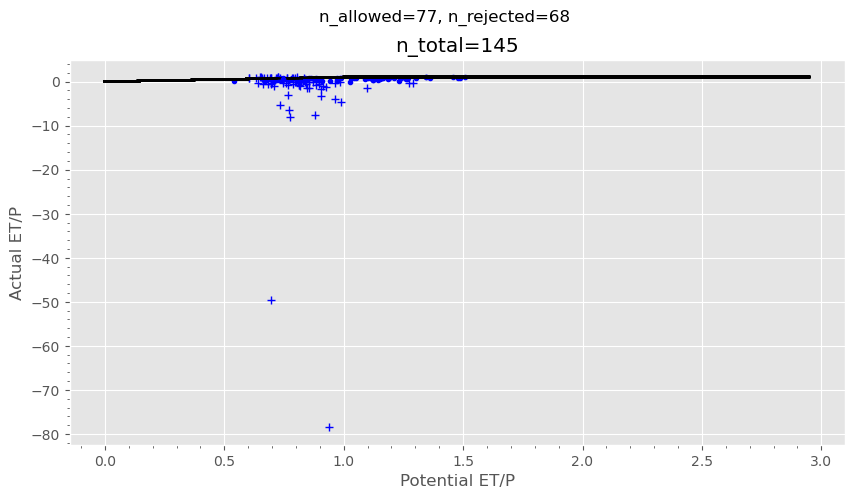

In [266]:
catchment_list = catchment_list_Lamah

n_total = 0
n_rejected  = 0
n_allowed = 0
negative_catchment_ids = []
plt.figure(figsize=(10,5))#.suptitle(f"LamaH (n={n_total-len(negative_catchment_ids)})",fontsize=20)
Ea_given = []
Ea_wb = []

for i in range(len(catchment_list)): 
    # Import data and select right dates
    data = pd.read_csv(f'{root}C_basins_intermediate_lowimp/2_timeseries/daily/'+str('ID_')+str(catchment_list[i])+str('.csv'),delimiter=';', skipinitialspace=True, na_values=-999)
    data['date'] = pd.to_datetime(data['YYYY'].astype('str')+
                                 data['MM'].astype('str')+
                                 data['DD'].astype('str'),
                           format='%Y%m%d')
    data.loc[:,'dt'] = pd.to_datetime(data['date'])
    data.index = data['dt']
    data = data["1989-01-01":"2009-12-31"]
    
    
    outputdata = pd.read_csv(f'{root}F_hydrol_model/2_timeseries/'+str('ID_')+str(catchment_list[i])+str('.csv'),delimiter=';', skipinitialspace=True, na_values=-999)
    outputdata['date'] = pd.to_datetime(outputdata['YYYY'].astype('str')+
                                 outputdata['MM'].astype('str')+
                                 outputdata['DD'].astype('str'),
                                        format='%Y%m%d')
    outputdata.loc[:,'dt'] = pd.to_datetime(outputdata['date'])
    outputdata.index = outputdata['dt']
    outputdata = outputdata["1989-01-01":"2009-12-31"]   
    
    data["qobs"] = outputdata["Qobs"]    
    
    # Compute mean values
    Ep = catch_att.loc[f"{catchment_list[i]}","et0_mean"]  # comes from catchment attributes 
    P = data['prec'].mean() 
    T = data['2m_temp_mean'].mean() 
    Q = data['qobs'].mean()
    Ea_calc = data['total_et'].mean()
    Ea_given.append(Ea_calc)
    
    # display(data)
    
    # Compute Ea, AI, EI
    Ea = P - Q
    Ea_wb.append(Ea)
    
    EI = Ea / P
    AI = Ep / P
    
    print(f'Catchment nr {i} ({catchment_list[i]}) has a given Ea of {Ea_calc} and Ea from P-Q of {Ea}, EI of {EI} and AI of {AI}')
        

    
    n_total += 1


    
    # Plot every catchment
    if Ea > 0 and AI > EI: 
        budyko_curve_x = np.arange(1, 3, 0.05)
        energy_limit_x = np.arange(0, 1.0001, 0.05)
        x = np.arange(0, 1.0001, 0.05)
        water_limit_y = 1 + budyko_curve_x*0
        energy_limit_y = energy_limit_x
        y = 1 + x*0
        plt.ylabel("Actual ET/P")
        plt.xlabel("Potential ET/P")
        plt.minorticks_on()
        plt.plot(energy_limit_x, energy_limit_y, c='k')
        plt.plot(budyko_curve_x, water_limit_y,c='k')
        n_allowed+=1
        
        plt.plot(AI, EI, marker='.', c = 'b')
    

    else:
        negative_catchment_ids.append(catchment_list[i])
        budyko_curve_x = np.arange(1, 3, 0.05)
        energy_limit_x = np.arange(0, 1.0001, 0.05)
        x = np.arange(0, 1.0001, 0.05)
        water_limit_y = 1 + budyko_curve_x*0
        energy_limit_y = energy_limit_x
        y = 1 + x*0
        plt.ylabel("Actual ET/P")
        plt.xlabel("Potential ET/P")
        plt.minorticks_on()
        plt.plot(energy_limit_x, energy_limit_y, c='k')
        plt.plot(budyko_curve_x, water_limit_y,c='k')
        n_rejected+=1

        plt.plot(AI, EI, marker='+', c = 'b')
plt.title(f'n_total={n_total}')
plt.suptitle(f'n_allowed={n_allowed}, n_rejected={n_rejected}')
        

In [246]:
list(np.where(np.array(negative_catchment_ids)>0)[0])

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67]

In [247]:
np.where(negative_catchment_ids>0)

TypeError: '>' not supported between instances of 'list' and 'int'